# Imports

In [ ]:
# #download the feature dataset
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz 

--2022-11-08 04:15:07--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.3’

aclImdb_v1.tar.gz.3 100%[===================>]  80.23M  18.4MB/s    in 9.0s    

2022-11-08 04:15:16 (8.90 MB/s) - ‘aclImdb_v1.tar.gz.3’ saved [84125825/84125825]



In [ ]:
import pandas as pd
import numpy as np
import math
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
%pip install -U libsvm-official
from libsvm.svmutil import *
from sklearn.datasets import load_svmlight_file
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.feature_extraction import text
extra = [*"@_!#$%^&*()<>?/\|0123456789"]
stop_words = text.ENGLISH_STOP_WORDS.union(frozenset(extra))

# IMDB Reviews

## Data Processing

In [ ]:
#load the feature dataset
#x is a list of dictionaries, each key is the feature mapping to the number of occurrences
#y is a list of ratings (1-10)
y_train, x_train = svm_read_problem("/content/aclImdb/train/labeledBow.feat")
y_train = np.array(y_train)
y_train = np.where(y_train <= 4, 0, y_train) #give 0 label to negative class ratings
y_train = np.where(y_train >= 7, 1, y_train) #give 1 label to positive class ratings

y_test, x_test = svm_read_problem("/content/aclImdb/test/labeledBow.feat")
y_test = np.array(y_test)
y_test = np.where(y_test <= 4, 0, y_test) #give 0 label to negative class ratings
y_test = np.where(y_test >= 7, 1, y_test) #give 1 label to positive class ratings

print("x train length: ", len(x_train))
print("x test length: ", len(x_test))
print("y train shape: ", y_train.shape)
print("y test shape: ", y_train.shape)

#vocab
with open("/content/aclImdb/imdb.vocab", encoding="utf8") as vocab:
  vocab = vocab.read()
vocab = np.array(vocab.split("\n")) #np array of shape (89527,)

x train length:  25000
x test length:  25000
y train shape:  (25000,)
y test shape:  (25000,)


In [ ]:
#all_words is an array which its index i indicates the word presented in vocab[i]
#all_words[i] is the number of documents that CONTAIN that word
all_words = np.zeros_like(vocab, dtype=int)
to_filter_train = np.empty(shape = (25000, len(vocab))) #np array of shape (25000, 89527)
for index, movie in enumerate(x_train):
  for feature in movie:
    if vocab[feature].lower() not in stop_words:
      all_words[feature] += 1 #when a feature occurs in a document
      to_filter_train[index][feature] += movie[feature] #count the number of times each feature for each movie


### Word Filtering
Processing the data by filtering out words that appear in less than 1% and more than 50% of the documents. 

In [ ]:
all_words_percentage = all_words/len(x_train) * 100
filtered_words_index = np.asarray(np.where(((all_words_percentage >= 1) & (all_words_percentage <= 50)))).reshape(-1)

#filtered_words is a nparray of words that appear >= than 1% and <= 50% of the documents
filtered_words = vocab[filtered_words_index] 
x_filtered = np.zeros(shape = (25000, filtered_words.shape[0]), dtype=int)
for index, movie in enumerate(to_filter_train):
  x_filtered[index] = movie[filtered_words_index]


all_words = np.zeros_like(vocab, dtype=int)
#Filtering words that are kept from the training set in x_test
to_filter_test = np.empty(shape = (25000, len(vocab))) #np array of shape (25000, 89527)
for index, movie in enumerate(x_test):
  for feature in movie:
    if vocab[feature].lower() not in stop_words:
      all_words[feature] += 1 #when a feature occurs in a document
      to_filter_test[index][feature] += movie[feature] #count the number of times each feature for each movie
    
x_filtered_test = np.zeros(shape = (25000, filtered_words.shape[0]), dtype=int)
for index, movie in enumerate(to_filter_test):
  x_filtered_test[index] = movie[filtered_words_index]
  
print("x_filtered_test shape is {}:".format(x_filtered_test.shape))
print("x_filtered shape is {}:".format(x_filtered.shape))
print("filtered words index shape: {}".format(filtered_words_index.shape))
print("filtered words shape: {}".format(filtered_words.shape))

x_filtered_test shape is (25000, 1518):
x_filtered shape is (25000, 1518):
filtered words index shape: (1518,)
filtered words shape: (1518,)


In [ ]:
print("standarlized y shape is ", y_train.shape)


standarlized y shape is  (25000,)


### Simple Linear Regression Hypothesis Testing
First, we will need standardize the vectors x and y in order to calculate the z-scores for each feature. 

In [ ]:
def standardize(arr):
  mean = np.mean(arr, axis=0)
  sd = np.std(arr, axis=0)
  standard = (arr - mean)/sd
  return standard

standardized_x = standardize(x_filtered)
standardized_y = standardize(y_train).reshape(-1,1)

z_scores = (np.dot(np.transpose(standardized_x), standardized_y)/np.sqrt(len(x_train))).reshape(-1)
z_scores_absolute = np.absolute(np.dot(np.transpose(standardized_x), standardized_y)/np.sqrt(len(x_train))).reshape(-1)

print("standarlized x shape is ", standardized_x.shape)
print("standarlized y shape is ", standardized_y.shape)
print("z-scores shape is ", z_scores.shape)

standarlized x shape is  (25000, 1518)
standarlized y shape is  (25000, 1)
z-scores shape is  (1518,)


Below is a histogram of the absolute z_scores. 

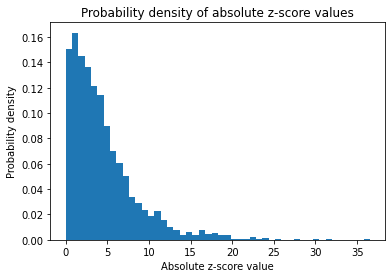

In [ ]:
_ = plt.hist(z_scores_absolute, bins="auto", density=True)
plt.xlabel("Absolute z-score value")
plt.ylabel("Probability density")
plt.title("Probability density of absolute z-score values")
plt.show()

In [ ]:
top_10_neg = np.argsort(z_scores)[:10] #index from vocab of top 10 neg z-scores
top_10_pos = np.argsort(z_scores)[-10:] #index from vocab of top 10 pos z-scores

print("The top 10 features with most negative z-scores are :", vocab[filtered_words_index[top_10_neg]])
print("The top 10 features with most positive z-scores are :", vocab[filtered_words_index[top_10_pos]])

The top 10 features with most negative z-scores are : ['worst' 'waste' 'awful' 'worse' 'terrible' 'boring' 'stupid' 'horrible'
 'poor' 'minutes']
The top 10 features with most positive z-scores are : ['favorite' 'loved' 'amazing' 'beautiful' 'perfect' 'love' 'best'
 'wonderful' 'excellent' 'great']


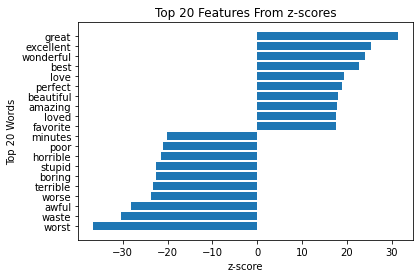

In [ ]:
top_20 = vocab[filtered_words_index[np.concatenate((top_10_neg, top_10_pos))]] #y-axis
top_20_zscore = z_scores[np.concatenate((top_10_neg, top_10_pos))] #x-axis

plt.barh(top_20, top_20_zscore)
plt.title("Top 20 Features From z-scores")
plt.xlabel("z-score")
plt.ylabel("Top 20 Words")
plt.savefig("bar_plot_top_20_words.png", bbox_inches='tight', dpi=300)
plt.show()

Clearly, we can see that the words with negative z-scores have a negative meaning and leads to believe that a review is not well rated. On the other hand, words with positive z-scores have a much more positive meaning and correlates well with a good movie review. 

Let's now choose the top 200 features by their absolute z-scores. 100 Are chosen from the most positive z-scores, and 100 is chosen from the most negative ones. 

In [ ]:
top_100_neg = np.argsort(z_scores)[:100] #index from vocab of top 100 neg z-scores
top_100_pos = np.argsort(z_scores)[-100:] #index from vocab of top 100 pos z-scores
top_200 = np.concatenate((top_100_neg, top_100_pos))

In [ ]:
x_train_final = x_filtered[:,top_200]
x_test_final = x_filtered_test[:,top_200]

print("x train final shape: ", x_train_final.shape)
print("x test final shape: ", x_test_final.shape)

x train final shape:  (25000, 200)
x test final shape:  (25000, 200)


### One Hot Encoding

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown="ignore")
# enc.fit(x_train_final)
# x_train_final = enc.transform(x_train_final)
# x_test_final = enc.transform(x_test_final)

# print("After one hot encoding, x train final shape: ", x_train_final.shape)
# print("After one hot encoding, x test final shape: ", x_test_final.shape)

## Logistic Regression

### Cost function
To fit our model, we are maximizing the **logarithm of the conditional likelihood** by substituing the definition of logistic function, and minimizing the **negative** of the log-likelihood, which is the **cost function** as follows:
\begin{equation*}
J(w) = \sum_n y^{(n)}log(1+e^{-xw^T}) + (1-y^{(n)})log(1+e^{xw^T})
\end{equation*}
We choose to use the mean rather than the sum of all data points as it is more practical. 

In [ ]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

### Gradient Descent 
In order to minimize the cost function, we will use gradient descent. Specifically, we will start from some initial assignment to the parameters *w*, and take a small step at each iteration in the opposite direction of the **gradient**. 
\begin{align*}
\frac{\partial}{\partial w_d} J(w) &=\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}}\\
&= \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} \\
&= x^{(n)}_d (\hat{y}^{(n)} - y^{(n)}) 
\end{align*}

Note that in the above cost function, we decided to use the mean. Thus, we will do the same here by dividing the gradient by *N*. 

### Logistic Regression Class

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z)) #logistic function
class LogisticRegression1:

    def __init__(self, add_bias=False, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        # x = x.toarray()
        yh = logistic(np.dot(x, self.w))    # predictions size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad

    def fit(self, x, y, x_valid=None, y_valid = None):
        # x = x.toarray()
        # x_valid = x_valid.toarray()
        losses_train = np.zeros(self.max_iters)
        losses_valid = np.zeros(self.max_iters)
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            # print("Iteration ", t)
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            losses_train[t] = cost_fn(x, y, self.w)
            if x_valid is not None:
                losses_valid[t] = cost_fn(x_valid, y_valid, self.w)
            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, losses_train, losses_valid

    def predict(self, x):
        # x = x.toarray()
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        yh = np.where(yh <= 0.5, 0, 1)
        return yh

### Convergence of Logistic Regression

(25000, 200)
(25000,)
<class 'numpy.ndarray'>


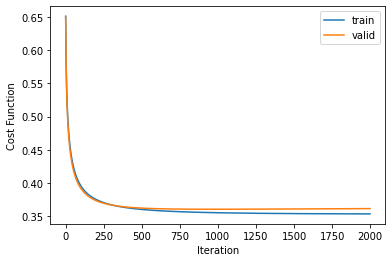

In [ ]:
from sklearn.model_selection import train_test_split
print(x_train_final.shape)
print(y_train.shape)
x_train, x_valid, y_train1, y_valid =  train_test_split(x_train_final, y_train, shuffle=True, test_size=0.3)
print(type(x_valid))
model = LogisticRegression1(max_iters=2000, learning_rate=1)
_, cost_train, cost_valid = model.fit(x=x_train, y=y_train1, x_valid=x_valid, y_valid=y_valid)

plt.clf()
plt.plot(cost_train, label='train')
plt.plot(cost_valid, label='valid')
plt.xlabel("Iteration")
plt.ylabel("Cost Function")
plt.legend()
plt.savefig("logistic_convergence.png", bbox_inches="tight", dpi=300)
plt.show()

### Top 20 Features From Logistic Regression
Below we also calculate the top 20 features obtained from the weights after fitting our Logistic Regression Model. 

The top 10 features with most negative weights are : ['waste' 'worst' 'poorly' 'awful' 'disappointment' 'dull' 'pointless'
 'laughable' 'wasted' 'avoid']
The top 10 features with most positive weights are : ['wonderful' 'amazing' 'perfect' 'fantastic' 'enjoyable' 'rare' 'favorite'
 'wonderfully' 'superb' 'excellent']


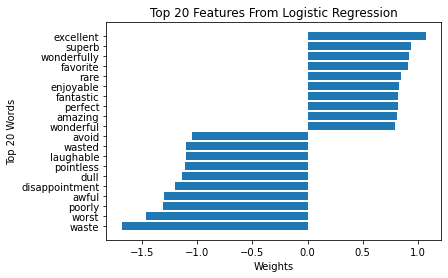

In [ ]:
model = LogisticRegression1(max_iters=1000, learning_rate=1)
model_fitted = model.fit(x_train_final, y_train)
weights = model_fitted[0].w

top_10_neg_log = np.argsort(weights)[:10] #index from vocab of top 10 neg weights
top_10_pos_log = np.argsort(weights)[-10:] #index from vocab of top 10 pos weights
print("The top 10 features with most negative weights are :", vocab[filtered_words_index[top_200[top_10_neg_log]]])
print("The top 10 features with most positive weights are :", vocab[filtered_words_index[top_200[top_10_pos_log]]])
top_20_logy = vocab[filtered_words_index[top_200[np.concatenate((top_10_neg_log, top_10_pos_log))]]] #y-axis
top_20_logx = weights[np.concatenate((top_10_neg_log, top_10_pos_log))] #x-axis

plt.barh(top_20_logy, top_20_logx)
plt.title("Top 20 Features From Logistic Regression")
plt.xlabel("Weights")
plt.ylabel("Top 20 Words")
plt.savefig("bar_plot_top_20_words_log.png", bbox_inches='tight', dpi=300)
plt.show()

We can see that the top 20 features from both the coefficients and z-scores give a good representation of whether a movie is good or bad. 

### Test accuracy of Logistic Regression as a function of training size

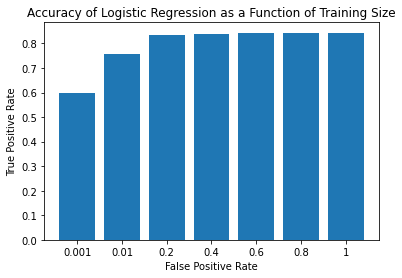

In [ ]:
perf = {}
percentages = [0.001, 0.01, 0.20, 0.40, 0.60, 0.80, 1]
aucs = []

for percentage in percentages:
    permutation = np.random.permutation(x_train_final.shape[0])
    permutation_selected = permutation[:int(percentage * x_train_final.shape[0])] #randomly select a percentage of training size
    permutated_x_train = x_train_final[permutation_selected,:]
    permutated_y_train = y_train[permutation_selected]
    
    model = LogisticRegression1(max_iters=1000, learning_rate=1)
    yh = model.fit(permutated_x_train, permutated_y_train)[0].predict(x_test_final) #testing on the whole test dataset
    auc = roc_auc_score(y_test, yh)
    aucs.append(auc)


plt.bar([str(x) for x in percentages], aucs)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Accuracy of Logistic Regression as a Function of Training Size")
plt.savefig('multi_training_size_log.png', bbox_inches='tight', dpi=300)
plt.show()
    

### Test accuracy based on different learning rates

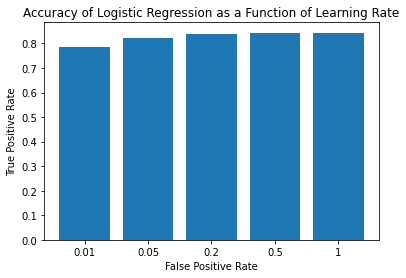

[0.7864800000000001, 0.8227200000000001, 0.8374, 0.84224, 0.8438]


In [ ]:
rates = [0.01, 0.05, 0.2, 0.5, 1]
aucs = [] 
for rate in rates:
    model = LogisticRegression1(max_iters=1000, learning_rate=rate)
    yh = model.fit(x_train_final, y_train)[0].predict(x_test_final) #testing on the whole test dataset
    auc = roc_auc_score(y_test, yh)
    aucs.append(auc)

plt.bar([str(x) for x in rates], aucs)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Accuracy of Logistic Regression as a Function of Learning Rate")
plt.savefig('multi_learning_rate_log.png', bbox_inches='tight', dpi=300)
plt.show()
print(aucs)

### Comparing Logistic Regression with Other Models


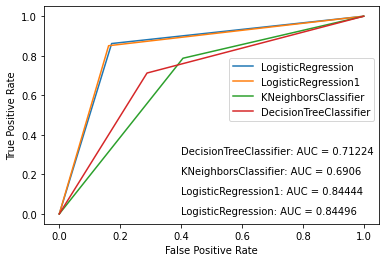

In [ ]:
models = [LogisticRegression(),
          LogisticRegression1(max_iters=2000, learning_rate=1),
          KNeighborsClassifier(),
          DecisionTreeClassifier()]
perf = {}

for model in models:
    model_name = type(model).__name__
    # print(model_name)
    if model_name == "LogisticRegression1":
        label, pred = y_test, model.fit(x_train_final, y_train)[0].predict(x_test_final)
    else:
        label, pred = y_test, model.fit(x_train_final, y_train).predict(x_test_final)
    fpr, tpr, _ = roc_curve(label, pred)
    auc = roc_auc_score(label, pred)
    perf[model_name] = {'fpr':fpr,'tpr':tpr,'auc':auc}

fig = plt.figure()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],
             label=model_name)
    plt.text(0.4, i, model_name + ': AUC = '+
             str(round(model_perf['auc'],7)))
    i += 0.1
    
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.45))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('roc_multimethods.png', bbox_inches='tight', dpi=300)
plt.show()

### Small pertubation to verify gradient
From class lectures, we have learnt that we can verify the gradient as follows:
1. $\epsilon \sim Uniform([0,1])$
2. $w^{(+)}_d = w_d + \epsilon$
3. $w^{(-)}_d = w_d - \epsilon$
4. $\nabla w_d = \frac{J(w^{(+)}_d) - J(w^{(-)}_d)}{2 \epsilon}$ (numerically estimated gradient)
5. $\frac{(\frac{\partial J(w)}{\partial w}  - \nabla w_d)^2}{(\frac{\partial J(w)}{\partial w}  + \nabla w_d)^2}$ must be small (e.g., $10^{-8}$) otherwise your gradient calculation and/or your loss function is incorrect

In [ ]:
N = 25000
x = x_train_final
y = y_train
y = y.reshape(25000,1)
# small perturbation
w = np.random.randn(1)
w0 = w
epsilon = np.random.randn(1)[0] * 1e-5
w1 = w0 + epsilon
w2 = w0 - epsilon
a1 = w1*x
a2 = w2*x
ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
dw_num = (ce1 - ce2)/(2*epsilon) # approximated gradient

yh = 1/(1+np.exp(-x * w))
dw_cal = np.sum((yh - y) * x) # hand calculated gradient

print(dw_cal)
print(dw_num)
print((dw_cal - dw_num)**2/(dw_cal + dw_num)**2)

107989.84778818364
107989.84786712736
1.3360087557197143e-19


## Linear and Ridge Regression
We will also use Linear Regression and Ridge Regression to try and predict the binary rating from the IMDB movie reviews. 

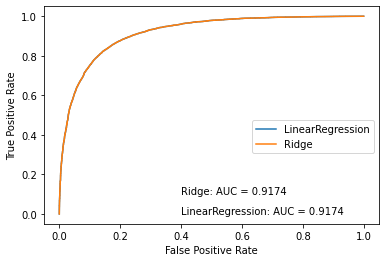

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

models = [LinearRegression(),
          Ridge()]
perf = {}

for model in models:
    model_name = type(model).__name__
    label, pred = y_test, model.fit(x_train_final, y_train).predict(x_test_final)
    fpr, tpr, _ = roc_curve(label, pred)
    auc = roc_auc_score(label, pred)
    perf[model_name] = {'fpr':fpr,'tpr':tpr,'auc':auc}

fig = plt.figure()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],
             label=model_name)
    plt.text(0.4, i, model_name + ': AUC = '+
             str(round(model_perf['auc'],4)))
    i += 0.1
    
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('Ridge_vs_LinearRegression.png', bbox_inches='tight', dpi=300)
plt.show()

# 20 News Groups


In [ ]:
#load dataset
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

categories = ['rec.sport.baseball', 'soc.religion.christian','comp.graphics', 'rec.motorcycles']
train = fetch_20newsgroups(subset="train", categories=categories, remove=(["headers", "footers", "quotes"]), shuffle=True, random_state=43)
x_train_news, y_train_news = train.data, train.target

#print("There is {} samples in x_train_news.".format(len(x_train_news)))
#print("\n".join(train.data[0].split("\n")[:3]))
#print(train.target[:20])

# Tokenization of data
count_vect = CountVectorizer(stop_words='english', max_df=0.5, min_df=0.01)
X_train_counts = count_vect.fit_transform(train.data)
X_array = X_train_counts.toarray()
num_documents = len(X_array)
num_tokens = len(X_array[0])
print(num_documents)
print(num_tokens)
print(len(X_array[1]))




2378
1081
1081


## Selecting the top feature words per class using Mutual Information

In [ ]:
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif

NUM_FEATURES = 100

# print(metrics.mutual_info_score(X_array, y_train_news))
y_one_hot_encoded = np.zeros((len(y_train_news), 4), dtype=int)
for i in range(len(y_train_news)):
  y_one_hot_encoded[i][y_train_news[i]] = 1

best_words_index = set()
for i in range(4):
  print(f"Index {i}: {train.target_names[i]}")

for y in range(4):
  l = []
  for x in range(num_tokens):
    l.append(metrics.mutual_info_score(y_one_hot_encoded[:,y], X_array[:,x]))

  l = np.array(l)
  largest = np.argpartition(l, -NUM_FEATURES)[-NUM_FEATURES:]
  print(f"----------------Category: {train.target_names[y]}----------------")
  for ind in largest:
    print(count_vect.get_feature_names_out()[ind])
    best_words_index.add(ind)

best_X_array = np.zeros((num_documents, len(best_words_index)), dtype=int)

for doc in range(len(X_array)):
  counter = 0
  for i in range(len(X_array[i])):
    if i in best_words_index:
      best_X_array[doc,counter] = int(X_array[doc,i])
      counter+=1






Index 0: comp.graphics
Index 1: rec.motorcycles
Index 2: rec.sport.baseball
Index 3: soc.religion.christian
----------------Category: comp.graphics----------------
bikes
years
religion
death
appreciated
information
points
league
baseball
write
tiff
hit
lines
help
truth
looking
think
ray
really
applications
mac
pub
mail
season
project
man
ms
algorithms
christian
use
surface
christianity
support
church
team
faith
advance
polygon
email
year
comp
convert
say
ride
data
dod
256
said
systems
did
info
hardware
directory
display
dos
video
vga
computer
version
colors
color
code
using
christians
file
screen
windows
files
formats
christ
unix
ftp
card
gif
god
graphics
hi
bike
bible
believe
image
images
available
site
interface
jesus
library
thanks
programs
mode
animation
programming
algorithm
program
package
pc
software
3d
people
format
----------------Category: rec.motorcycles----------------
screen
exists
create
things
buy
fans
belief
word
teams
question
lord
st
true
words
convert
street
win
worl

Split the data into training, validation, and testing

In [ ]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    best_X_array, y_one_hot_encoded, test_size = 0.33, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

Multiclass Regression

In [ ]:
from numpy import linalg
from scipy import special

class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)   

    def predict(self, X):
        Z = np.matmul(X, self.W)
        Z = Z - Z.max(axis=-1, keepdims=True)
        y_pred = np.exp(Z)
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)    

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(special.xlogy(y,self.predict(X)))

    def fit(self, X, y, X_valid=None, y_valid=None, epsilon=1e-2, lr=0.001, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            if linalg.norm(self.grad(X, y)) < epsilon:
              break
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                # if loss_valid>losses_valid[i-1] and i>1:
                #   break
                losses_valid[i] = loss_valid
                # print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            # else:
                # print(f"Spec iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


Create Multinomial Logistic Regression model object and check Gradient

In [ ]:
D = best_X_array.shape[1]
C = y_one_hot_encoded.shape[1]
mlr = Multinomial_logistic(D, C)


#Check Gradient
# print(mlr.check_grad(X_train, y_train))

Fitting the multinomial logistic model

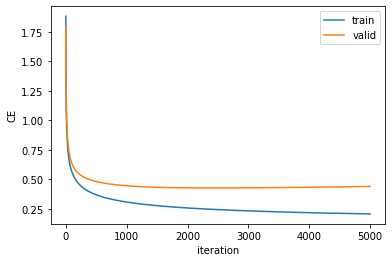

<Figure size 432x288 with 0 Axes>

In [ ]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, lr = 0.0005, niter=5000)

plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

From the above plot, we can see that with learning rate 0.0005, the change in the cross entropy for the validation set is basically 0 after 1500 iterations

In [ ]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print("Training accuracy: ", train_accuracy)
print("Validation accuracy: ",valid_accuracy)
print("Testing accuracy: ",test_accuracy)


Training accuracy:  0.9195979899497487
Validation accuracy:  0.8080301129234629
Testing accuracy:  0.8089171974522293


## Implementing KNN on the dataset

Testing KNN with 20%, 40%, 60% and 80% of the data for training

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

training_size = [0.2,0.4,0.6,0.8]
KNN_accuracies = []
for size in training_size:
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
    best_X_array, y_one_hot_encoded, train_size = size, shuffle=True)
  
  # Model training
  knn = KNeighborsClassifier(n_neighbors = 5) # n_neighbors=5 (default)
  fit = knn.fit(X_train, y_train)

  y_train_pred = fit.predict(X_train)
  y_test_pred = fit.predict(X_test)

  sum_acc_train = 0
  sum_acc_test = 0
  for i in range(len(y_train)):
    if np.array_equal(y_train_pred[0],y_train[0]):
      sum_acc_train += 1

  for i in range(len(y_test)):
    if np.array_equal(y_test_pred[i],y_test[i]):
      sum_acc_test += 1

  acc_train = sum_acc_train/len(y_train)
  acc_test = sum_acc_test/len(y_test)

  print(f"--------------- Training Size: {size} ---------------")
  print(f"Accuracy of train: {acc_train}")
  print(f"Accuracy of test: {acc_test}")
  KNN_accuracies.append(acc_test)

--------------- Training Size: 0.2 ---------------
Accuracy of train: 0.0
Accuracy of test: 0.4550709406200736
--------------- Training Size: 0.4 ---------------
Accuracy of train: 1.0
Accuracy of test: 0.5529081990189209
--------------- Training Size: 0.6 ---------------
Accuracy of train: 1.0
Accuracy of test: 0.5808823529411765
--------------- Training Size: 0.8 ---------------
Accuracy of train: 1.0
Accuracy of test: 0.5672268907563025


## Heatmap

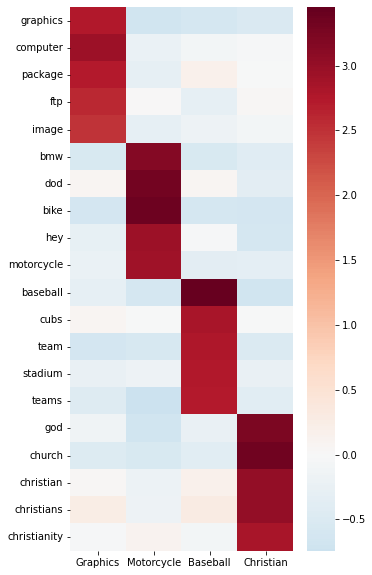

In [ ]:
from seaborn import heatmap
W_hat = mlr.W
plt.figure(figsize = (5,10))
map = np.zeros(shape=(20,4))
y_labels = []
count=0
for i in range(4):
  temp = np.argpartition(-W_hat[:,i], 5)
  result_args = temp[:5]
  y_labels += result_args.tolist()

  for j in result_args:
    map[count] = W_hat[j]
    count+=1

y_actual_labels = []
original_indices = sorted(list(best_words_index))
for i in range(len(y_labels)):
  y_actual_labels.append(count_vect.get_feature_names_out()[original_indices[y_labels[i]]])

hmp = heatmap(map, cmap='RdBu_r', center=0, yticklabels = y_actual_labels, xticklabels=['Graphics','Motorcycle','Baseball','Christian'])

fig = hmp.get_figure()
fig.savefig("heatmap.png", bbox_inches="tight")

## Comparing accuracy of Multiclass Regression based on training size

In [ ]:
training_size = [0.2,0.4,0.6,0.8]
MLR_accuracies = []

for size in training_size:
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
    best_X_array, y_one_hot_encoded, train_size = size, shuffle=True)

  mlr = Multinomial_logistic(D, C)

  ce_train, ce_valid = mlr.fit(X_train, y_train, lr = 0.0005, niter=1500)

  train_accuracy = evaluate(mlr.predict(X_train), y_train)
  test_accuracy = evaluate(mlr.predict(X_test), y_test)

  print(f"--------------- Training Size: {size} ---------------")
  print("Training accuracy: ",train_accuracy)
  print("Test accuracy: ",test_accuracy)
  print()
  MLR_accuracies.append(test_accuracy)

--------------- Training Size: 0.2 ---------------
Training accuracy:  0.9073684210526316
Test accuracy:  0.7992643194955333

--------------- Training Size: 0.4 ---------------
Training accuracy:  0.9011566771819137
Test accuracy:  0.8234057463209531

--------------- Training Size: 0.6 ---------------
Training accuracy:  0.8920056100981767
Test accuracy:  0.8371848739495799

--------------- Training Size: 0.8 ---------------
Training accuracy:  0.8890641430073607
Test accuracy:  0.8403361344537815



## KNN vs Multiclass Regression with different training sizes

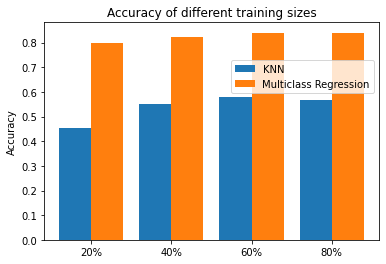

In [ ]:
X = ['20%','40%','60%','80%']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, KNN_accuracies, 0.4, label = 'KNN')
plt.bar(X_axis + 0.2, MLR_accuracies, 0.4, label = 'Multiclass Regression')

plt.xticks(X_axis, X)
plt.ylabel("Accuracy")
plt.title("Accuracy of different training sizes")
plt.legend()
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.65))
plt.savefig("KNN vs Multiclass Regression.png", bbox_inches="tight")
plt.show()


## Trying different learning rates

Previously, we fixed the learning rate and number of iterations for each training size. However, this caused the higher training sizes to converges extremely slowly. Let's see how we can play around with the values to increase the convergence rate.

--------------- Learning Rate: 0.0005 ---------------
Training accuracy:  0.9367088607594937
Test accuracy:  0.7540725170782975

--------------- Learning Rate: 0.005 ---------------
Training accuracy:  0.9493670886075949
Test accuracy:  0.7456647398843931

--------------- Learning Rate: 0.05 ---------------
Training accuracy:  0.9493670886075949
Test accuracy:  0.7388334209143458

--------------- Learning Rate: 0.1 ---------------
Training accuracy:  0.9451476793248945
Test accuracy:  0.7498686284813453

--------------- Learning Rate: 0.0001 ---------------
Training accuracy:  0.8987341772151899
Test accuracy:  0.7241198108250131

--------------- Learning Rate: 0.001 ---------------
Training accuracy:  0.9451476793248945
Test accuracy:  0.7787703625853915



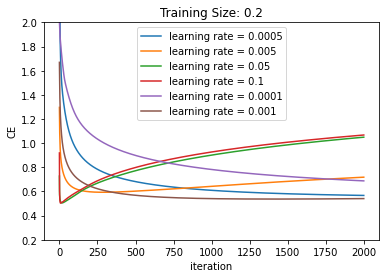

--------------- Learning Rate: 0.0005 ---------------
Training accuracy:  0.9136842105263158
Test accuracy:  0.8051857042747022



KeyboardInterrupt: ignored

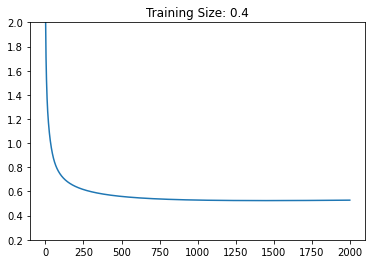

In [ ]:
learning_rates = [0.0005, 0.005, 0.05, 0.1, 0.0001, 0.001]

for size in training_size:
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
      best_X_array, y_one_hot_encoded, train_size = size, shuffle=True)

  X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
      X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

  plt.clf()
  plt.title(f"Training Size: {size}")
  plt.ylim(0.2, 2)
  for lr in learning_rates:
    D = best_X_array.shape[1]
    C = y_one_hot_encoded.shape[1]
    mlr = Multinomial_logistic(D, C)

    ce_train, ce_valid = mlr.fit(X_train, y_train,X_valid, y_valid, lr = lr, niter=2000)
    
    plt.plot(ce_valid/X_valid.shape[0], label=f'learning rate = {lr}')
    

    train_accuracy = evaluate(mlr.predict(X_train), y_train)
    test_accuracy = evaluate(mlr.predict(X_test), y_test)

    print(f"--------------- Learning Rate: {lr} ---------------")
    print("Training accuracy: ",train_accuracy)
    print("Test accuracy: ",test_accuracy)
    print()

  plt.xlabel("iteration")
  plt.ylabel("CE")
  plt.legend()
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1))
  plt.savefig(f"learning_rate_vs_train_size_{size*100}.png",bbox_inches="tight")
  plt.show()